In [13]:
from matplotlib import pyplot as plt
import platform, os, sys
import numpy as np
from tabulate import tabulate
from pprint import pprint

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis

%matplotlib inline
%config InlineBackend.figure_format='retina'

Could not import BEM module. Please do so manually.


In [14]:
# Evaluate all files in the range
xeval=np.linspace(-3, 4, 151)
yeval = np.linspace(-2, 2, 151)

save = True
save_path = "..\\Maxwell\\M017 Yggdrasil Greater Trap Area\\CutIn 1p5 um"
datafiles = [os.path.join(save_path, "Resonator.dsp"),
             os.path.join(save_path, "Trap.dsp"),
             os.path.join(save_path, "ResonatorGuard.dsp"),
             os.path.join(save_path, "CenterGuard.dsp"), 
             os.path.join(save_path, "TrapGuard.dsp")]

output = list()
names = ['resonator', 'trap', 'resonatorguard', 'centerguard', 'trapguard']
for name, datafile in zip(names, datafiles):
    plt.figure(figsize=(14.,4.))
    common.configure_axes(13)
    elements, nodes, elem_solution, bounding_box = trap_analysis.load_dsp(os.path.join(datafile))
    xdata, ydata, Udata = interpolate_slow.prepare_for_interpolation(elements, nodes, elem_solution)
    xcenter = np.mean(bounding_box[0:2])
    ycenter = np.mean(bounding_box[2:4])
    xdata -= xcenter
    ydata -= ycenter
    xinterp, yinterp, Uinterp = interpolate_slow.plot_BC(xdata, ydata, Udata, xeval=xeval, yeval=yeval, clim=(0, 1.0), 
                                                         plot_axes='xy', cmap=plt.cm.Spectral_r, plot_mesh=False)
    output.append({'name' : name, 'V' : np.array(Uinterp.T, dtype=np.float64),
                               'x' : np.array(xinterp.T, dtype=np.float64), 'y' : np.array(yinterp.T, dtype=np.float64)})
    
    plt.vlines(-1.5, -2.0, 2.0, linestyles="--", color="gray")

FileNotFoundError: [Errno 2] No such file or directory: '..\\Maxwell\\M017 Yggdrasil Greater Trap Area\\CutIn 1p5 um/Resonator.dsp'

In [40]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

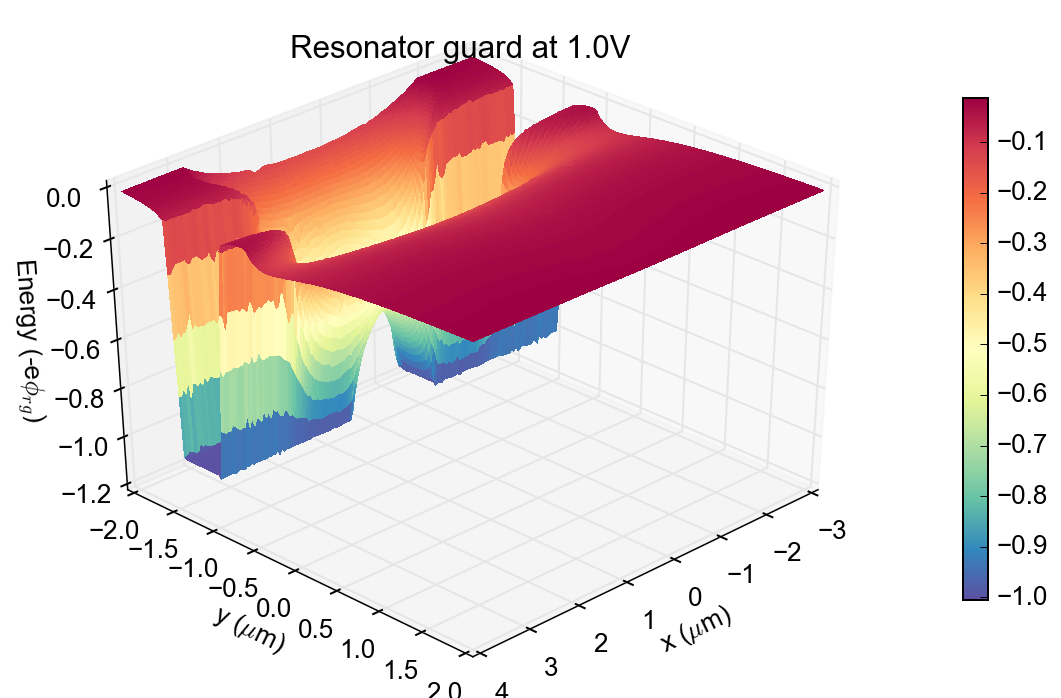

In [41]:
fig = plt.figure(figsize=(10.,6.))
common.configure_axes(13)
ax = fig.gca(projection='3d')

Xm, Ym = meshgrid(xeval, yeval)
Zm = output[2]['V']

surf = ax.plot_surface(Xm, Ym, -Zm, rstride=1, cstride=1, cmap=plt.cm.Spectral_r,
                       linewidth=0, antialiased=False)
ax.set_xlabel("x ($\mu$m)")
ax.set_ylabel("y ($\mu$m)")
ax.set_zlabel("Energy (-e$\phi_{rg}$)")
ax.view_init(elev=35., azim=+45)
ax.set_title("Resonator guard at 1.0V")

fig.colorbar(surf, shrink=0.75, aspect=20)

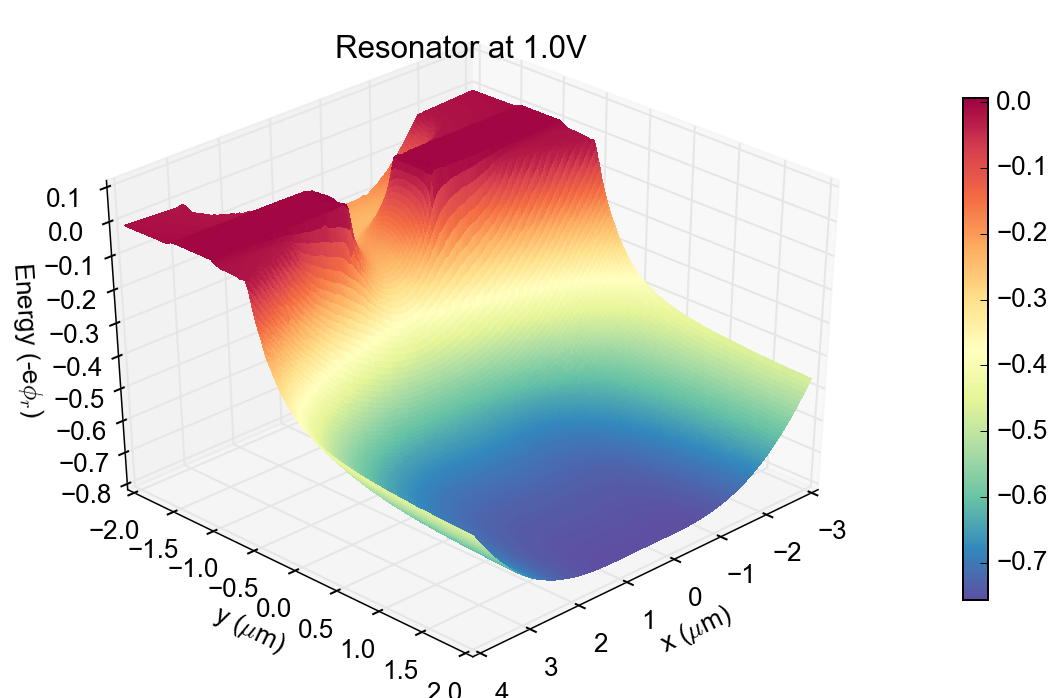

In [42]:
fig = plt.figure(figsize=(10.,6.))
common.configure_axes(13)
ax = fig.gca(projection='3d')

Xm, Ym = meshgrid(xeval, yeval)
Zm = output[0]['V']

surf = ax.plot_surface(Xm, Ym, -Zm, rstride=1, cstride=1, cmap=plt.cm.Spectral_r,
                       linewidth=0, antialiased=False)
ax.set_xlabel("x ($\mu$m)")
ax.set_ylabel("y ($\mu$m)")
ax.set_zlabel("Energy (-e$\phi_r$)")

ax.view_init(elev=35., azim=+45)
ax.set_title("Resonator at 1.0V")

fig.colorbar(surf, shrink=0.75, aspect=20)

# How strong do electrodes contribute to barrier potential $V_b$?

We would like to describe the potential at the barrier in terms of the resonator voltage $V_r$ and the resonator guard $V_{rg}$: 

$$ V_b = \alpha V_{res} + \beta V_{trap} + \gamma V_{rg} + \delta V_{cg} + \epsilon V_{tg}$$

To find $\alpha$ through $\epsilon$ let's plot the energy across the channel when 1V is applied to each of the electrodes:

alpha = 0.215
beta = 0.010
gamma = 0.657
delta = 0.034
epsilon = 0.017


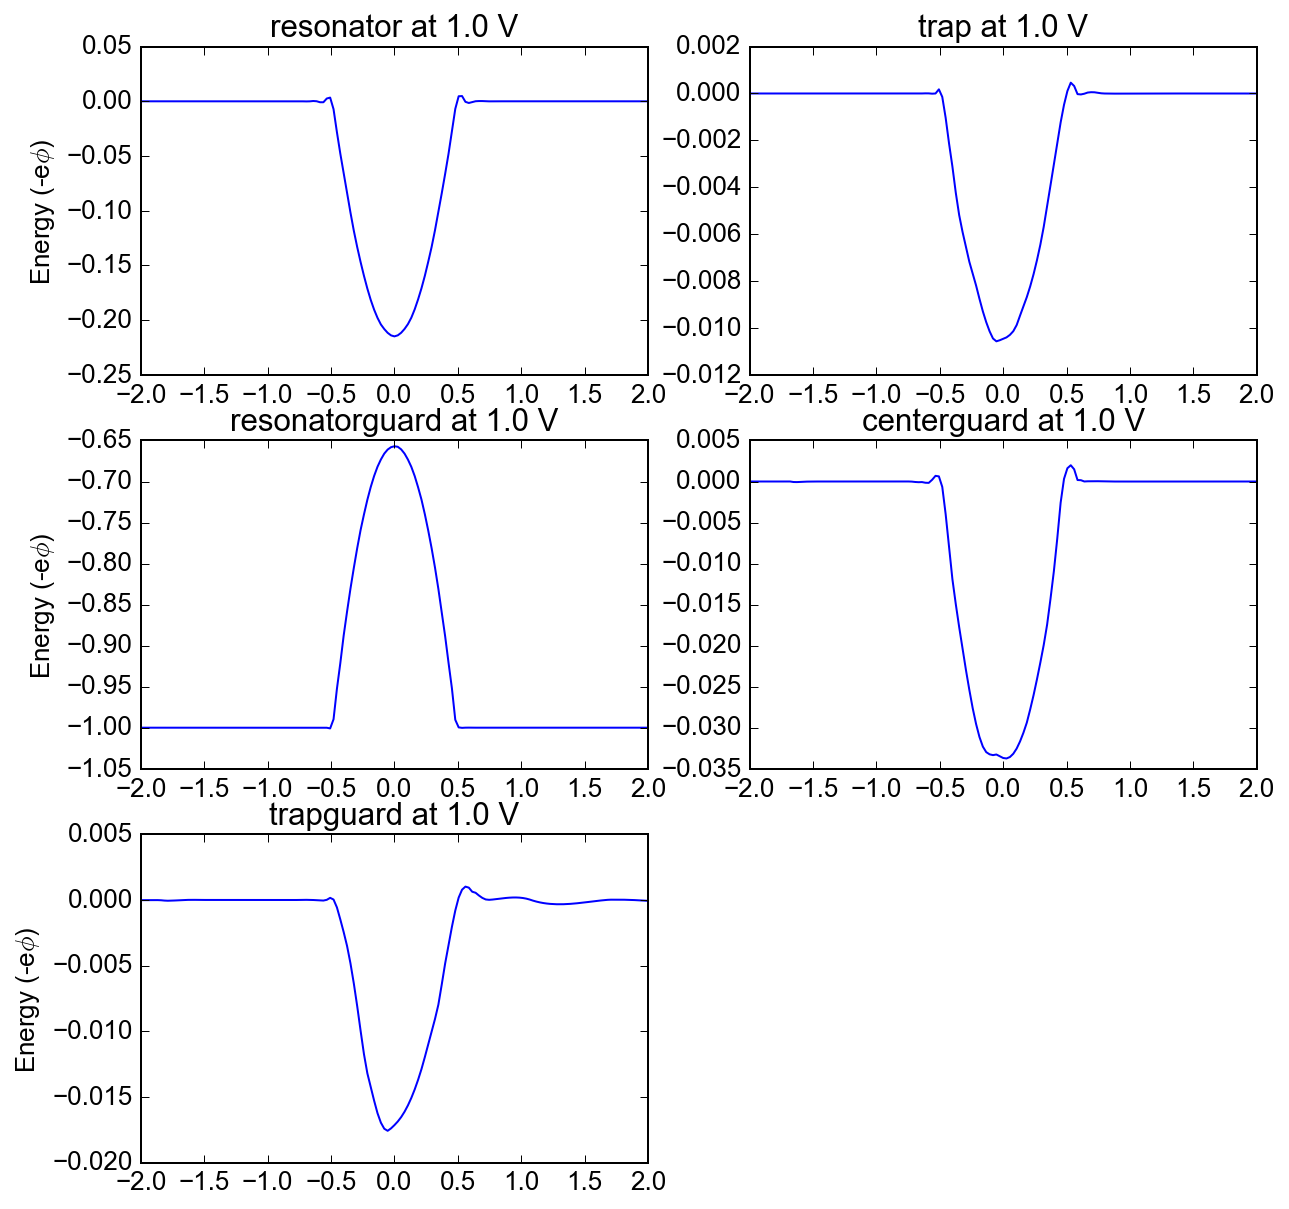

In [49]:
xoi = -1.5
xoi_idx = common.find_nearest(xeval, xoi)
ctr_idx = common.find_nearest(yeval, 0)

names = ['alpha', 'beta', 'gamma', 'delta', 'epsilon']
voltage_coefficients = list()

fig = plt.figure(figsize=(10.,10.))
    
for i in range(5):
    plt.subplot("32%d"%(i+1))
    plt.plot(yeval, -output[i]['V'][xoi_idx,:])
    if not i%2:
        plt.ylabel("Energy (-e$\phi$)")
    #if i in [4,5]:
    #    plt.xlabel("x ($\mu$m)")
    plt.title("%s at 1.0 V"%output[i]['name'])

    print "%s = %.3f"%(names[i], output[i]['V'][xoi_idx,ctr_idx])
    
    voltage_coefficients.append(output[i]['V'][xoi_idx,ctr_idx])
    
if save: 
    common.save_figure(fig, save_path=save_path)

And so it follows that to good approximation we can neglect all but the resonator and the resonator guard electrode: $V_b = 0.17 V_r + 0.67 V_{rg}$. 
This makes sense, since the resonator guard should have much more influence on the barrier than the resonator. The resonator is further away from the point at which we measure the potential. 

For the electron potential $V_e$, we need to look at the reservoir, in this case the resonator. Let's take a look at a cut across the channel and determine $\eta$ in

$$ V_e = \eta V_r - \frac{e n_s d}{\epsilon \epsilon_0} $$

eta = 0.76


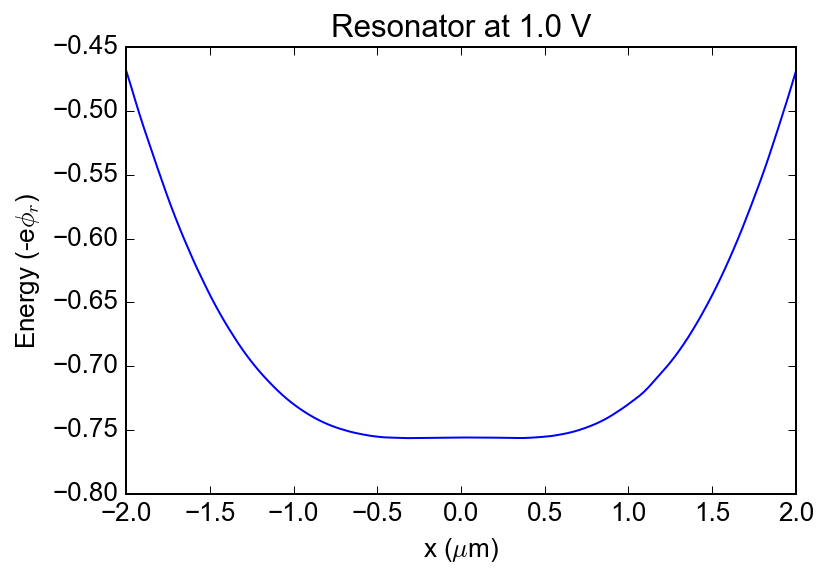

In [44]:
xoi = +4.0
xoi_idx = common.find_nearest(xeval, xoi)
ctr_idx = common.find_nearest(yeval, 0)

plt.figure(figsize=(6.,4.))
plt.plot(yeval, -output[0]['V'][xoi_idx,:])
plt.ylabel("Energy (-e$\phi_r$)")
plt.xlabel("x ($\mu$m)")
plt.title("Resonator at 1.0 V")

print "eta = %.2f"%(output[0]['V'][xoi_idx,ctr_idx])

And so it follows that 

$$ V_e = 0.70 V_r - \frac{e n_s d}{\epsilon \epsilon_0} = 0.70 V_r - \Delta V$$

Now we're able to make an energy diagram, plotting $-eV_e$ and $-eV_b$ as a function of $V_r$ and $V_{rg}$ 

# Example of combined potential landscape 

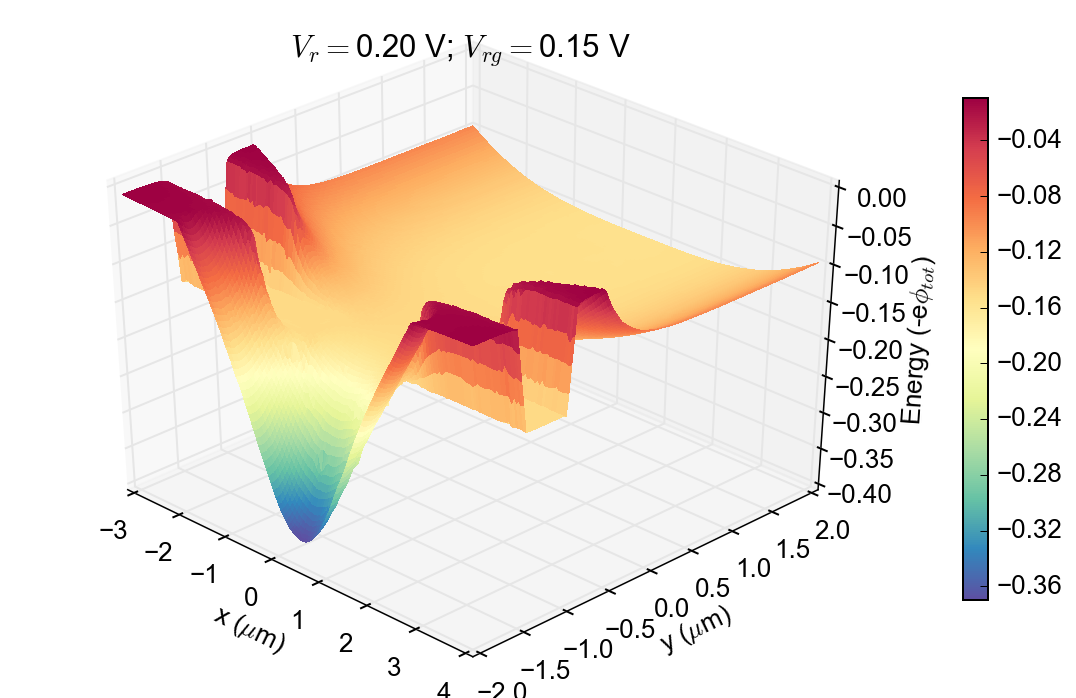

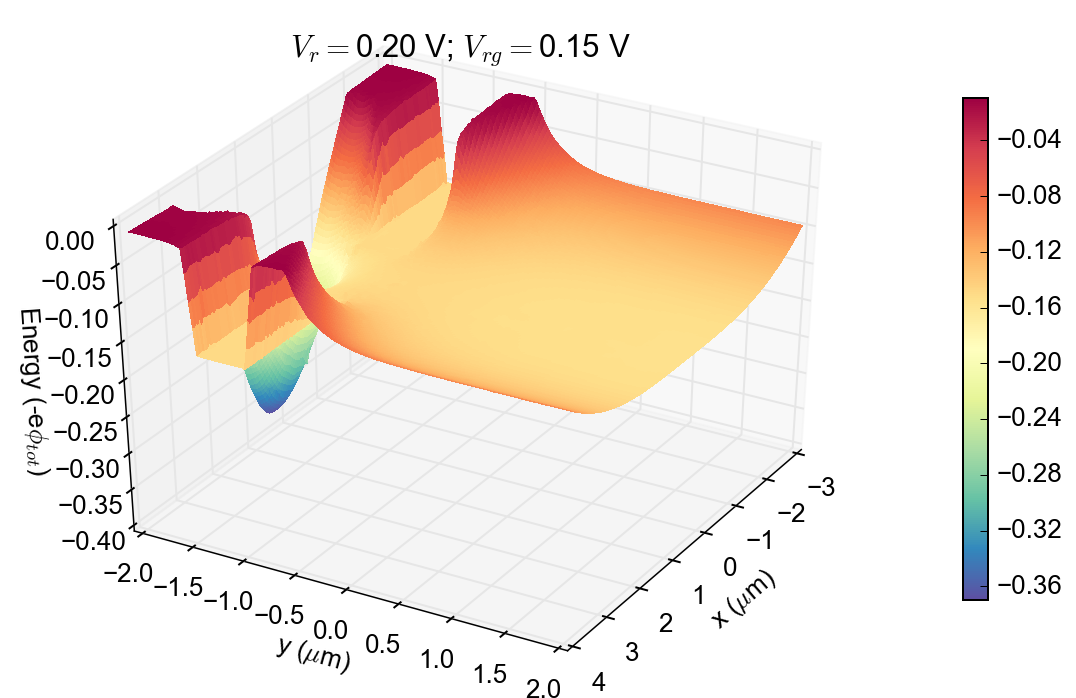

In [45]:
Xm, Ym = meshgrid(xeval, yeval)
Vr = output[0]['V']
Vt = output[1]['V']
Vrg = output[2]['V']

# These are the actual voltages you put on the electrodes
Vr_coef = 0.20
Vrg_coef = 0.15
Vt_coef = 1.50

Zm = Vr_coef * Vr + Vrg_coef * Vrg + Vt_coef * Vt

for view_angle in [-45, 30]:
    fig = plt.figure(figsize=(10.,6.))
    common.configure_axes(13)
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(Xm, Ym, -Zm, rstride=1, cstride=1, cmap=plt.cm.Spectral_r,
                           linewidth=0, antialiased=False)
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    ax.set_zlabel("Energy (-e$\phi_{tot}$)")
    ax.view_init(elev=35., azim=view_angle)
    fig.colorbar(surf, shrink=0.75, aspect=20)
    plt.title("$V_r = $%.2f V; $V_{rg} = $%.2f V"%(Vr_coef, Vrg_coef))
    
    common.save_figure(fig, save_path=save_path)

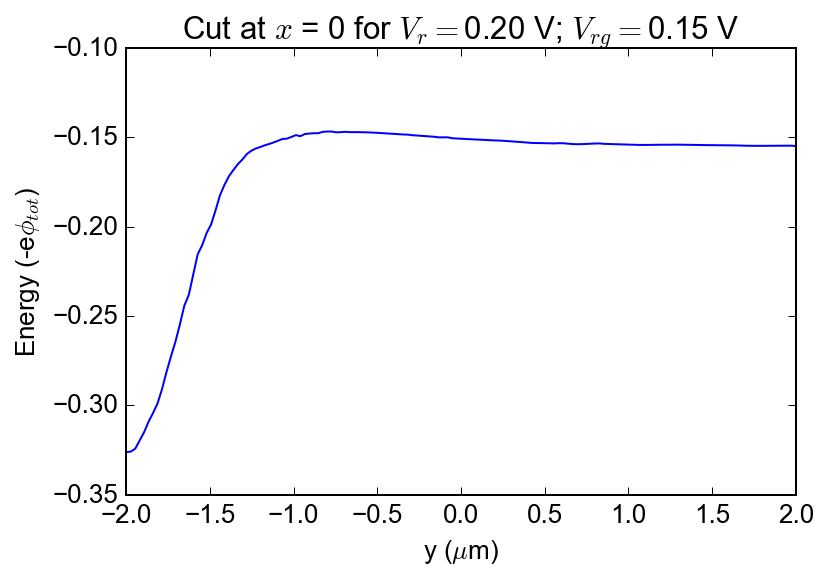

In [46]:
xoi = 0
xoi_idx = common.find_nearest(xeval, 0)

plt.figure(figsize=(6.,4.))
plt.plot(Ym[:,xoi_idx], -Zm[:, xoi_idx])
plt.xlabel("y ($\mu$m)")
plt.ylabel("Energy (-e$\phi_{tot}$)")
plt.title("Cut at $x$ = 0 for $V_r = $%.2f V; $V_{rg} = $%.2f V"%(Vr_coef, Vrg_coef))

common.save_figure(fig, save_path=save_path)

# Expected successful loading conditions

Loading should be successful when $-eV_e > -e V_b$. In terms of the separate electrodes, we have

$$ -e\eta V_r + \frac{e^2 n_s d}{\epsilon \epsilon_0} > -e \left( \alpha V_r + \beta V_{t} + \ldots + \epsilon V_{tg} \right)  $$

Rewriting this for $n_s$, we get

$$ n_s > \frac{\epsilon \epsilon_0}{e d} \left( (\eta-\alpha) V_r -\beta V_{t} -\gamma V_{rg} - \delta V_{cg} - \epsilon V_{tg}\right)$$

Let us only investigate the influence of $V_r$ and $V_{rg}$

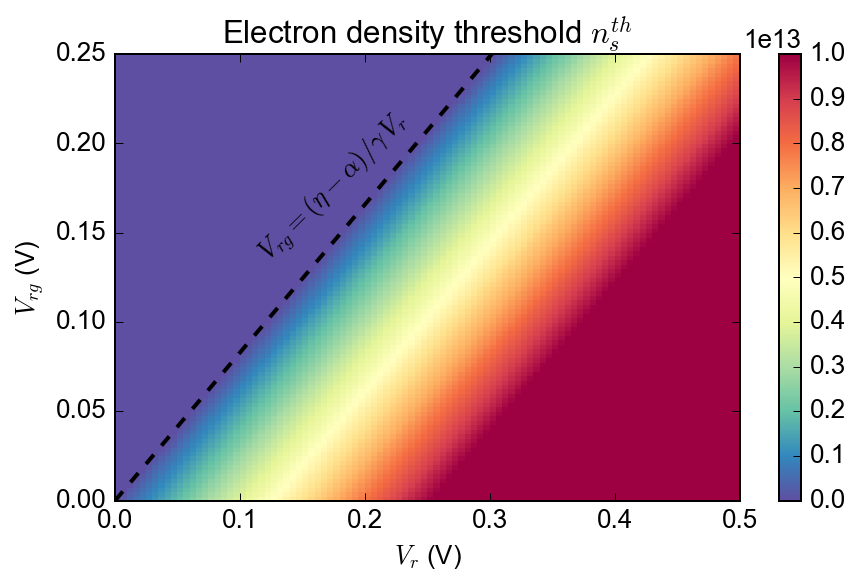

In [47]:
c = trap_analysis.get_constants()
helium_depth = 800E-9
alpha = voltage_coefficients[0]
gamma = voltage_coefficients[2]
eta = 0.76

vr = np.linspace(0., 0.5, 101)
vrg = np.linspace(0., 0.25, 101)

VR, VRG = np.meshgrid(vr, vrg)
NS_TH = 1.056 * c['eps0']/(c['e'] * helium_depth) * ((eta - alpha)*VR - gamma*VRG)
NS_TH[NS_TH < 0] = 0
NS_TH[NS_TH > 1E13] = 1E13

fig = plt.figure(figsize=(7.,4.))
plt.pcolormesh(VR, VRG, NS_TH, cmap=plt.cm.Spectral_r)
plt.plot(vr, (eta-alpha)/gamma * vr, '--k', lw=2.0)
plt.xlabel('$V_r$ (V)')
plt.ylabel('$V_{rg}$ (V)')
plt.title("Electron density threshold $n_s^{th}$")
plt.ylim(np.min(vrg), np.max(vrg))
plt.text(0.11, 0.13, r"$V_{rg} = (\eta-\alpha)/\gamma \,V_r$", rotation=45, ha='left', va='bottom')
plt.colorbar()

common.save_figure(fig, save_path=save_path)